In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv("species_biome_env_dataset.csv")

# Biome and species setup
biome_lookup = {
    1: "Tropical Forest", 2: "Temperate Forest", 3: "Boreal Forest",
    4: "Tropical Grassland", 5: "Temperate Grassland", 6: "Desert",
    7: "Shrubland", 8: "Tundra", 9: "Flooded Grassland", 10: "Mangroves",
    11: "Mediterranean", 12: "Montane", 13: "Xeric Shrubland", 14: "Ice and Rock"
}
species_cols = [
    "axolotl", "blue_macaw", "ocelot", "black_iguana", "resplendent_quetzal",
    "coyote", "crested_caracara", "green_turtle", "american_alligator", "asian_elephant"
]
biome_ids = sorted(df["BIOME"].dropna().unique())

# Matrix and metrics storage
compatibility_matrix_xgb_tuned = pd.DataFrame(index=species_cols, columns=[biome_lookup.get(b, f"Biome {b}") for b in biome_ids])
tuned_metrics = []

# Scoring
f1_scorer = make_scorer(f1_score, zero_division=0)

# Grid parameters
param_grid = {
    "max_depth": [3, 6],
    "learning_rate": [0.1, 0.3],
    "n_estimators": [100, 200],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

In [3]:
metrics = []

# Loop over species
for species in species_cols:
    print(f"\n Tuning XGBoost for: {species}")
    y = df[species].astype(int)

    env_cols = [col for col in df.columns if col.startswith("BIO")]
    biome_encoded = pd.get_dummies(df["BIOME"], prefix="BIOME")
    X = pd.concat([df[env_cols], biome_encoded], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True))
    y = y.loc[X.index]

    if y.value_counts().min() < 2:
        print(f"Skipping {species} due to insufficient class diversity.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as ve:
        print(f"Skipping {species} — split error: {ve}")
        continue

    # Calculate scale_pos_weight
    pos = sum(y_train == 1)
    neg = sum(y_train == 0)
    spw = neg / pos if pos > 0 else 1

    xgb_base = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=spw
    )

    grid = GridSearchCV(
        xgb_base,
        param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1
    )

    try:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    except Exception as e:
        print(f" Training failed for {species}: {e}")
        continue

    y_pred = best_model.predict(X_test)
    probas = best_model.predict_proba(X_scaled)[:, 1]

    print(f"Best F1: {f1_score(y_test, y_pred):.3f} | Params: {grid.best_params_}")

    tuned_metrics.append({
        "Species": species,
        "Model": "XGBoost (Tuned)",
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0)
    })

    # Fill compatibility matrix
    df_temp = df.loc[X.index].copy()
    df_temp["pred_prob"] = probas
    biome_avg = df_temp.groupby("BIOME")["pred_prob"].mean()

    for biome_id, prob in biome_avg.items():
        biome_label = biome_lookup.get(biome_id, f"Biome {biome_id}")
        compatibility_matrix_xgb_tuned.loc[species, biome_label] = round(prob, 3)


 Tuning XGBoost for: axolotl


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.025 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

 Tuning XGBoost for: blue_macaw


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.274 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

 Tuning XGBoost for: ocelot


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.586 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

 Tuning XGBoost for: black_iguana


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.309 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

 Tuning XGBoost for: resplendent_quetzal


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.132 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

 Tuning XGBoost for: coyote


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.835 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

 Tuning XGBoost for: crested_caracara


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.294 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

 Tuning XGBoost for: green_turtle


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.558 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 Tuning XGBoost for: american_alligator


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best F1: 0.236 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 Tuning XGBoost for: asian_elephant
Best F1: 0.248 | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [4]:
# Save tuned metrics
tuned_xgb_df = pd.DataFrame(tuned_metrics)
tuned_xgb_df.to_csv("xgb_tuned_metrics.csv", index=False)

# Save new matrix
compatibility_matrix_xgb_tuned = compatibility_matrix_xgb_tuned.fillna("–")
compatibility_matrix_xgb_tuned.to_csv("xgb_tuned_matrix.csv")
display(compatibility_matrix_xgb_tuned)

/tmp/ipython-input-4-1417173384.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  compatibility_matrix_xgb_tuned = compatibility_matrix_xgb_tuned.fillna("–")


,Tropical Forest,Temperate Forest,Boreal Forest,Tropical Grassland,Temperate Grassland,Desert,Shrubland,Tundra,Flooded Grassland,Mangroves,Mediterranean,Montane,Xeric Shrubland,Ice and Rock,Biome 26.265860931353888,Biome 98.0,Biome 99.0
axolotl,0.220,0.570,0.844,0.672,0.005,0.019,0.007,0.005,0.019,0.664,0.017,0.007,0.624,0.004,0.001,0.004,0.004
blue_macaw,0.631,0.432,0.009,0.125,0.181,0.018,0.851,0.095,0.920,0.029,0.039,0.403,0.080,0.085,0.022,0.234,0.037
ocelot,0.717,0.737,0.672,0.007,0.020,0.012,0.723,0.060,0.567,0.839,0.034,0.112,0.319,0.687,0.052,0.045,0.024
black_iguana,0.223,0.814,0.902,0.043,0.055,0.023,0.070,0.058,0.296,0.026,0.040,0.019,0.430,0.755,0.002,0.025,0.025
resplendent_quetzal,0.610,0.748,0.791,0.072,0.078,0.009,0.003,0.002,0.403,0.637,0.057,0.020,0.117,0.716,0.004,0.577,0.011
coyote,0.087,0.266,0.732,0.727,0.943,0.989,0.066,0.932,0.044,0.006,0.986,0.268,0.624,0.252,0.135,0.946,0.774
crested_caracara,0.565,0.756,0.650,0.202,0.123,0.011,0.565,0.183,0.618,0.779,0.025,0.010,0.491,0.705,0.041,0.295,0.033
green_turtle,0.580,0.596,0.466,0.364,0.270,0.016,0.481,0.175,0.549,0.449,0.037,0.872,0.565,0.905,0.966,0.041,0.041
american_alligator,0.146,0.044,0.090,0.731,0.807,0.124,0.558,0.455,0.546,0.051,0.089,0.146,0.304,0.067,0.006,0.196,0.053
asian_elephant,0.700,0.746,0.552,0.406,0.238,0.014,0.340,0.036,0.024,0.636,0.035,0.132,0.288,0.522,0.131,0.172,0.592


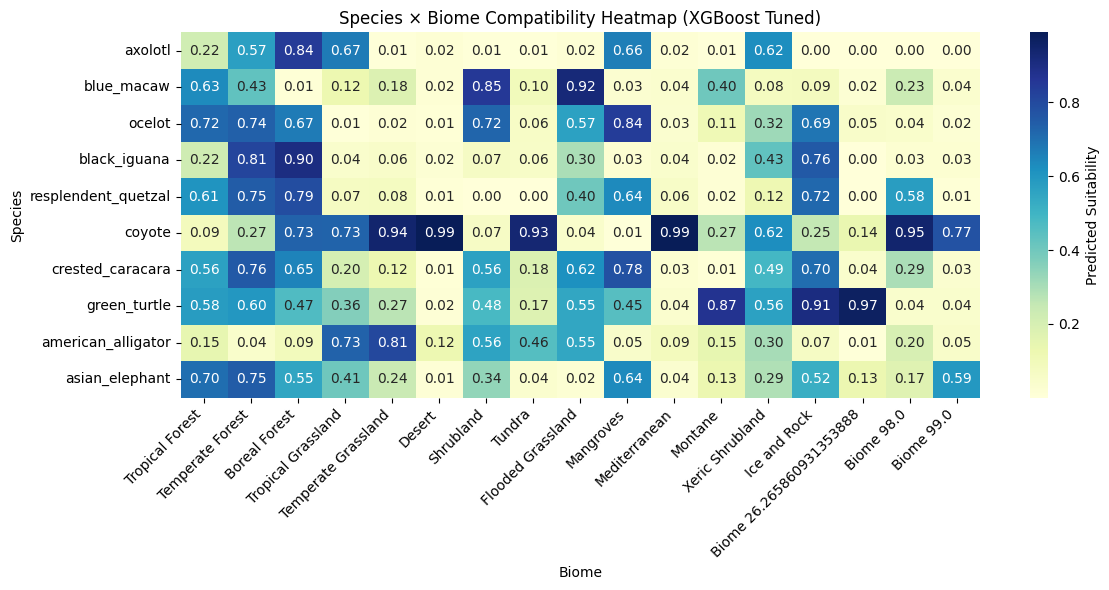

In [5]:
# Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

# Convert values to float (in case of "–")
heatmap_data = compatibility_matrix_xgb_tuned.replace("–", np.nan).astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Predicted Suitability"})
plt.title("Species × Biome Compatibility Heatmap (XGBoost Tuned)")
plt.xlabel("Biome")
plt.ylabel("Species")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()